**Rede convolucional para identificação de células de tecido sanguíneo apartir de imagens de microscópio**

Tentativa com SKLEARN (Waldeyr 01-03-2021)

Inspirado (quase totalmente copiado) de https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits

In [4]:
# Bibliotecas Python necessárias
import os
import zipfile
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Upload dos dados a partir de um arquivo .zip**





In [2]:
uploaded = files.upload()

Saving blood_v2.zip to blood_v2.zip


In [5]:
local_zip = '/content/blood_v2.zip' # Caminho referente ao local onde os dados são armazenados quando é feito o upload manualmente
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

class_names = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo']
nb_classes = len(class_names)
image_size = (150,150)

**Lendo dados descompactados a partir do drive**


In [6]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/blood/train/eosinofilo')
# Diretorio com imagens de validação de eosinofilo 
valid1 = os.path.join('/content/blood/valid/eosinofilo')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/blood/train/linfocito')
# Diretorio com imagens de validação de linfocito 
valid2 = os.path.join('/content/blood/valid/linfocito')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/blood/train/monocito')
# Diretorio com imagens de validação de monocito 
valid3 = os.path.join('/content/blood/valid/monocito')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/blood/train/neutrofilo')
# Diretorio com imagens de validação de neutrofilo 
valid4 = os.path.join('/content/blood/valid/neutrofilo')

print('total train eosinofilo:', len(os.listdir(train1)))
print('total valid eosinofilo:', len(os.listdir(valid1)))

print('total train linfocito:', len(os.listdir(train2)))
print('total valid linfocito:', len(os.listdir(valid2)))

print('total train monocito:', len(os.listdir(train3)))
print('total valid monocito:', len(os.listdir(valid3)))

print('total train neutrofilo:', len(os.listdir(train4)))
print('total valid neutrofilo:', len(os.listdir(valid4)))

total train eosinofilo: 2497
total valid eosinofilo: 623
total train linfocito: 2483
total valid linfocito: 620
total train monocito: 2478
total valid monocito: 620
total train neutrofilo: 2499
total valid neutrofilo: 624


## Normalização e Input dos dados

In [7]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset(path_list):
    datasets = path_list
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['eosinofilo']: label = 0
            elif folder in ['linfocito']:  label = 1
            elif folder in ['monocito']:   label = 2
            elif folder in ['neutrofilo']: label = 3
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [8]:
# Combinar todas as imagens originais em um único dataset
images, labels = loadDataset(['/content/blood/train/','/content/blood/valid/', '/content/blood/test/'])

100%|██████████| 6/6 [00:00<00:00, 622.70it/s]


In [47]:
# Embaralhar os dados e separar novos conjuntos de  treinamento (80%), validação (10%) e teste (10%)
images, labels = shuffle(images, labels, random_state=10)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

ValueError: ignored

In [9]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Quantidade de imagens para treinamento: {}".format(n_train))
print("Quantidade de imagens para validação: {}".format(n_val))
print("Quantidade de imagens para teste: {}".format(n_test))

print("Formato das imagens de treinamento: {}".format(train_images.shape))
print("Labels das imagens de treinamento: {}".format(train_labels.shape))
print("Formato das imagens de validação: {}".format(val_images.shape))
print("Labels das imagens de validação: {}".format(val_labels.shape))
print("Formato das imagens de teste: {}".format(test_images.shape))
print("Labels das imagens de teste: {}".format(test_labels.shape))


Quantidade de imagens para treinamento: 10012
Quantidade de imagens para validação: 1252
Quantidade de imagens para teste: 1251
Formato das imagens de treinamento: (10012, 150, 150, 3)
Labels das imagens de treinamento: (10012,)
Formato das imagens de validação: (1252, 150, 150, 3)
Labels das imagens de validação: (1252,)
Formato das imagens de teste: (1251, 150, 150, 3)
Labels das imagens de teste: (1251,)


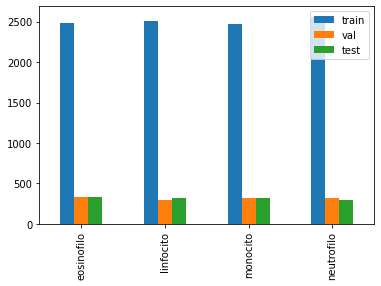

In [12]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

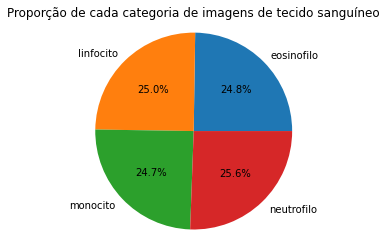

In [13]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção de cada categoria de imagens de tecido sanguíneo')
plt.show()

**Normalização dos dados**

In [14]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

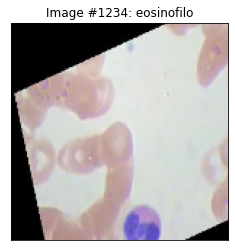

In [15]:
# Checagem com imagem aleatória
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

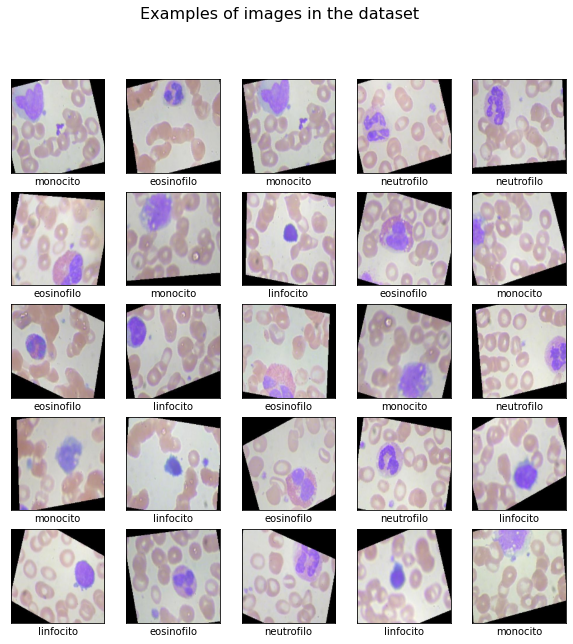

In [16]:
# Checagem com exemplos de imagens de cada categoria
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

**Construção do modelo**

In [17]:
model = Sequential()

# Primeira camada concolucional
model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada concolucional
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada concolucional
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Quarta camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Quinta camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))

# Camada de saída
model.add(Dense(units = 4 , activation = 'softmax'))

# Compilação
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='/content/BloodModel.h5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [18]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    plt.show()

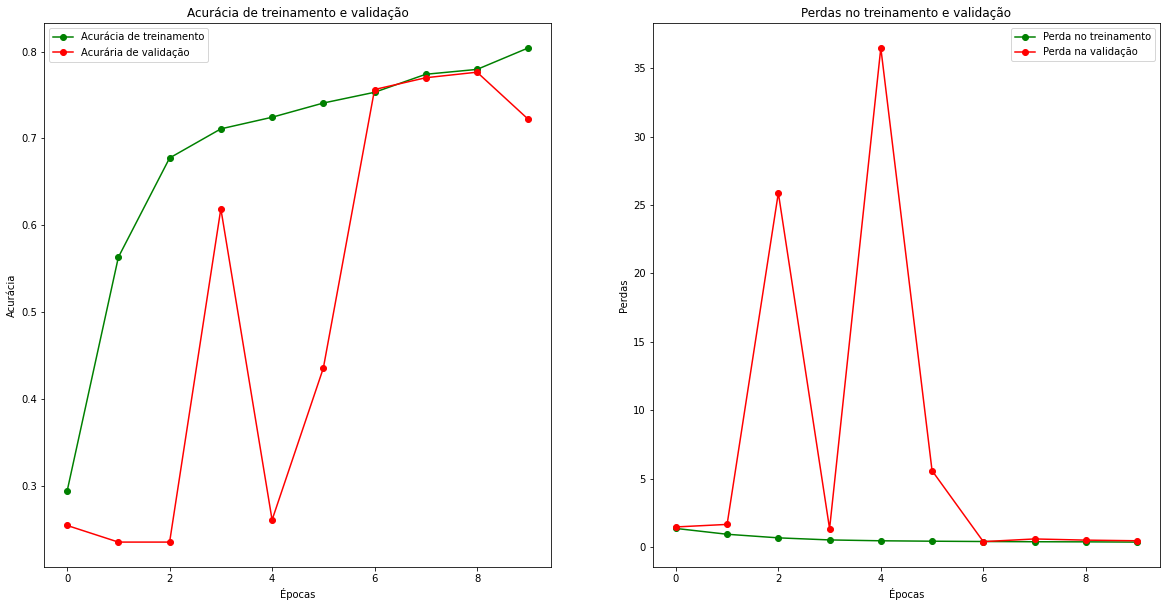

In [19]:
# Usando a função plotAcuracia
plotAccucaria(history)


In [20]:
# Resultados do treinamento da CNN

results = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", results[0])
print("Acurácia do modelo = ", results[1]*100, "%")

40/40 [==============================] - 1s 14ms/step - loss: 0.4347 - accuracy: 0.7258
Perda do modelo =  0.4346592128276825
Acurácia do modelo =  72.58193492889404 %


In [21]:
# Salvar o modelo
model.save('BloodModel.h5')

In [22]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([2, 1, 3, 2, 2, 3, 0, 3, 3, 3, 1, 3, 3, 3, 2])

In [23]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['eosinófilo (Class 0)', 'linfócito (Class 1)', 'monócito (Class 2)', 'neutrófilo (Class 3)']))

                      precision    recall  f1-score   support

eosinófilo (Class 0)       0.67      0.01      0.02       328
 linfócito (Class 1)       1.00      0.96      0.98       313
  monócito (Class 2)       0.96      0.98      0.97       314
neutrófilo (Class 3)       0.47      1.00      0.64       296

            accuracy                           0.73      1251
           macro avg       0.78      0.74      0.65      1251
        weighted avg       0.78      0.73      0.65      1251



In [24]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,4,0,0,324
1,1,299,12,1
2,1,0,309,4
3,0,0,0,296


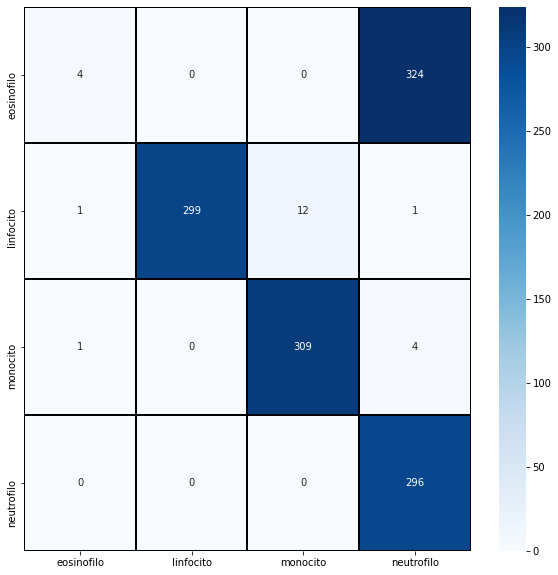

In [26]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

### Nova visualização

In [31]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset(path_list):
    datasets = path_list
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['eosinofilo']: label = 0
            elif folder in ['linfocito']:  label = 1
            elif folder in ['monocito']:   label = 2
            elif folder in ['neutrofilo']: label = 3
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [33]:
img, labels = loadDataset(['/content/blood/test'])

100%|██████████| 6/6 [00:00<00:00, 603.87it/s]


In [34]:
y_true = labels

In [35]:
y_true

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1], dtype=int32)

In [37]:
import glob
from keras import models
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image
# Avaliação com o transfer learning
test_set = glob.glob('/content/blood/test/**/*jpeg')
# Carregar o modelo com melhor loss
#model = load_model('chest_orientation_model.hdf5')

image_test = np.array([tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(image_name, target_size=(150,150), color_mode = 'rgb'))/255 for image_name in test_set])
y_pred = model.predict(image_test)

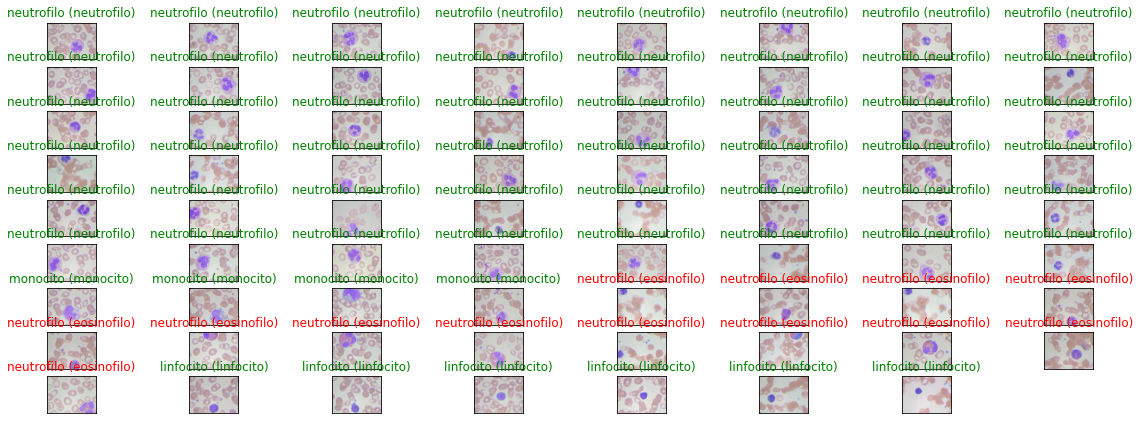

In [45]:

#Model - Sem Transfer Learning
labels = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo']
figure = plt.figure(figsize=(20,8))

for i in range(71):
    ax = figure.add_subplot(10,8,i+1, xticks=[], yticks=[])
    # Display image
    im = plt.imread(test_set[i])
    ax.imshow(im)
    predict_index = np.argmax(y_pred[i])
    true_index = y_true[i]
    # Set the title for each image
    ax.set_title("{}".format(labels[true_index]))
    # print(predict_index)
    ax.set_title(f"{labels[predict_index]} ({labels[true_index]})",
                                 color=("green" if predict_index == true_index else "red"))